<a id='logbook'></a>
# Roll decay damping
This is the notebook that created the report.

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

Duplicate key in file WindowsPath('C:/Users/maa/.matplotlib/stylelib/paper.mplstyle'), line 462 ('figure.figsize   : 5, 3   ## figure size in inches')
Duplicate key in file WindowsPath('C:/Users/maa/.matplotlib/stylelib/paper.mplstyle'), line 463 ('figure.dpi       : 100        ## figure dots per inch')


In [2]:
import os
import matplotlib.pyplot as plt
import pandas as pd
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999
pd.set_option("display.max_columns", None)
import sympy as sp

import pandas as pd
import numpy as np

if os.name == 'nt':
    plt.style.use('paper.mplstyle')  # Windows

import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from sklearn.metrics import r2_score
from scipy.integrate import solve_ivp
import seaborn as sns

from copy import deepcopy
from src.notebook_to_latex import Equation, equation_dict
from src import equations,symbols
import reports.paper_writing
from src.df_to_latex import LateXTable
from src.data.helpers import load
from src.visualization import rolldecay
import src.visualization.regression
from src.simulation import simulate
from src.models import regression

from rolldecayestimators.substitute_dynamic_symbols import run,lambdify
from rolldecayestimators import filters

## Examples:


Duplicate key in file 'paper.mplstyle', line 462 ('figure.figsize   : 5, 3   ## figure size in inches')
Duplicate key in file 'paper.mplstyle', line 463 ('figure.dpi       : 100        ## figure dots per inch')


In [3]:
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf','png')
from IPython.display import HTML, Markdown, Image
from src.df_to_latex import LateXTable

# Abstract
The roll damping of a ship at 0 knots is determined with time series from scale model roll decay tests and CFD simulations using a parameter identification technique (PIT).

# Introduction
The present dataset contains roll decay tests from actual model tests, carried out at SSPA maritime-dynamics-laboratory (www.sspa.se) and also CFD simulations, using a method called FNPF. The roll damping is determined by identifying the roll damping parameters in a prescribed mathematical model for the decaying roll motion. The roll angle time series from a roll decay model test is shown in Fig.[(below)](#fig_rolldecay_example).

The analysis for this report can also be found at:
* GitHub: https://github.com/martinlarsalbert/roll_decay_damping
* Binder: https://mybinder.org/v2/gh/martinlarsalbert/roll_decay_damping/HEAD?filepath=reports%2Freport%2F01.1.report.ipynb

<a id='fig_rolldecay_example>'></a>

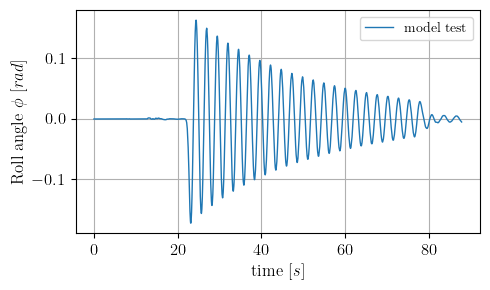

In [4]:
data = pd.read_csv('../../data/external/model_test_21340.csv', index_col=0)
fig,ax=plt.subplots()
data.plot(y='phi', ax=ax, label='model test');
ax.set_ylabel(r'Roll angle $\phi$ $[rad]$')
ax.set_xlabel(r'time $[s]$')
ax.grid(True)

The oscillating motion can be described by a spring-mass-damper system as seen in Fig.[(below)](#fig_spring_mass_damper).

<a id="fig_spring_mass_damper"></a>

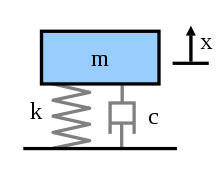

In [5]:
Image('../figures/220px-Mass_spring_damper.svg.png')

This system can me described as the following ordinary differential equation:

In [6]:
Equation(equations.roll_decay_equation_general_himeno, label='roll_decay_equation_general_himeno')

<src.notebook_to_latex.Equation object>

Where $B_{44}(\dot{\phi})$ and $C_{44}(\phi)$ are the damping and stiffness models. A cubic model can be obtained by using cubic damping:

In [7]:
Equation(equations.b44_cubic_equation, label='b44_cubic_equation')

<src.notebook_to_latex.Equation object>

And cubic stiffness model:

In [8]:
Equation(equations.restoring_equation_cubic, label='restoring_equation_cubic')

<src.notebook_to_latex.Equation object>

The total equation is then written:

In [9]:
Equation(equations.roll_decay_equation_quadratic_, label='roll_decay_equation_quadratic', max_length=200)

<src.notebook_to_latex.Equation object>

This equation does not have one unique solution however. If all parameters would be  multiplied by a factor $k$ these parameters would also yield as a solution to the equation. All parameters are therefore divided by the total inertia $A_{44}$ (including added mass inertia), replacing the parameters with new normalized parameters such as: $B_{1A} = B_1/A_{44}$. The equation is now rewritten with these new parameters which have unique solutions:

<a id="eq_roll_decay_equation_quadratic_a"></a>

In [10]:
Equation(equations.roll_decay_equation_quadratic_A, label='roll_decay_equation_quadratic_a', max_length=200)

<src.notebook_to_latex.Equation object>

In [11]:
B_1A, B_2A, B_3A, C_1A, C_3A, C_5A = sp.symbols('B_1A, B_2A, B_3A, C_1A, C_3A, C_5A')

# Data
The data used in this study is described in Tab.[(below)](#tab_data_files). There is one result with a pure FNPF simulation at 0 knots. For model test results, two tests are available at 0 knots and one test at 15.5 knots. There is also a result at 15.5 with a hybrid method, where semi empirical viscosity has been injected into the FNPF calculations.

<a id="tab_data_files"></a>

In [12]:
content = pd.read_csv('../../data/external/content.csv', sep=';')
table_parameters = content.round(decimals=3)
content.set_index('file', inplace=True)

rename = {}
units = {
    'Ship speed' : r'$[kts]$',
}

table_parameters['data file'] = table_parameters['data file'].apply(lambda x : x.replace('_',r' '))


lt = LateXTable(table_parameters, units=units, rename=rename, caption='Data files', label='data_files')
lt

[Index(['file', 'data file', 'Ship speed', 'Method'], dtype='object'),
 array(['', '', '$[kts]$', ''], dtype=object),
 array([1, 'fnpf kvlcc2 rolldecay 0kn.csv', 0.0, 'FNPF'], dtype=object),
 array([2, 'model test 21337.csv', 0.0, 'model test'], dtype=object),
 array([3, 'model test 21338.csv', 0.0, 'model test'], dtype=object),
 array([4, 'model test 21340.csv', 15.5, 'model test'], dtype=object),
 array([5, 'fnpf kvlcc2 rolldecay 15-5kn ikeda dev.csv', 15.5, 'hybrid'],
       dtype=object)]

Fig. [(below)](#fig_all_tests) shows the roll angle time series for all the tests. It can also be seen that test 1 and 5 also have time series for the roll angle velocity and acceleration from the conducted FNPF simulations. For the model test (2,3,4) velocities and accelerations were not measured during the tests. 

<a id="fig_all_tests">

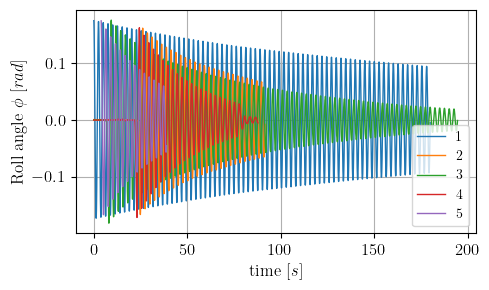

In [13]:
fig,ax=plt.subplots()
    
for file, row in content.iterrows():
    
    data = load(row['data file'])
    rolldecay.plot(data, y='phi', ax=ax, label=file);

ax.set_ylabel(r'Roll angle $\phi$ $[rad]$')
ax.set_xlabel(r'time $[s]$')
ax.grid(True)

<a id="fig_vel_acc"></a>

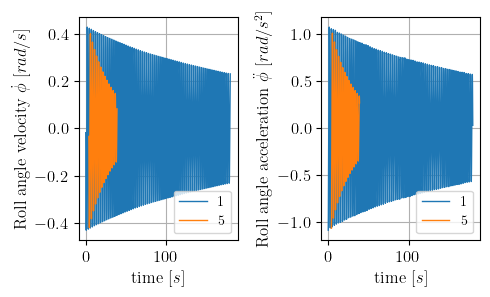

In [14]:
fig,axes=plt.subplots(ncols=2)
    
for file, row in content.iterrows():
    
    data = load(row['data file'])
    
    if 'phi1d' in data:
        rolldecay.plot(data, y='phi1d', ax=axes[0], label=file);
        
    if 'phi2d' in data:
        rolldecay.plot(data, y='phi2d', ax=axes[1], label=file);

        
axes[0].set_ylabel(r'Roll angle velocity $\dot\phi$ $[rad/s]$')
axes[0].set_xlabel(r'time $[s]$')
axes[0].grid(True)

axes[1].set_ylabel(r'Roll angle acceleration $\ddot\phi$ $[rad/s^2]$')
axes[1].set_xlabel(r'time $[s]$')
axes[1].grid(True)

# Analysis

## FNPF
The FNPF results have the benifit of having all the three states: $\phi$, $\dot{\phi}$ and $\ddot{\phi}$. This means that these time series can be inserted into the differential equation (Eq.[(see)](#eq_roll_decay_equation_quadratic_a)) and the parameters of the model can be estimated using linear regression with Ordinary Least Square method (OLS), solving the following regression:

<a id="eq_ols"></a>

In [15]:
 Equation(r'y = X \cdot \beta + \epsilon', label='ols')

<src.notebook_to_latex.Equation object>

where:
* $y$ is the dependent variable (also called "label"). 
* $\beta$ is a vector with the regressed parameters.
* $X$ is a matrix containing the independent variables (also called "features").

The roll decay equation can be expressed as a linear regression with
* $y$ : the roll angle acceleration $\ddot{\phi}$ 
* $\beta$ : contains all the parameters : $B_1$, $B_2$, $C_1$...
* $X$ : contains all the time varying features such as: $| \dot{\phi} | \dot{\phi} $ etc.

The roll acceleration is put on the left hand side:

<a id="eq_acceleration_equation_cubic"></a>

In [16]:
diff_eq_cubic = regression.DiffEqToMatrix(roll_decay_equation=equations.roll_decay_equation_cubic_A)
Equation(diff_eq_cubic.acceleration_equation, label='acceleration_equation_cubic')

<src.notebook_to_latex.Equation object>

In [17]:
Equation(diff_eq_cubic.acceleration_equation_x,'acceleration_equation_cubic_x')

<src.notebook_to_latex.Equation object>

The equation for the acceleration Eq.[(above)](#eq_acceleration_equation_cubic) can now be rewritten as a linear regression (see in Eq.[(above)](#eq_ols)) where $\beta$, $X$ and $y$ contain the following:

In [18]:
Equation(diff_eq_cubic.eq_beta,'eq_beta')

<src.notebook_to_latex.Equation object>

In [19]:
Equation(diff_eq_cubic.eq_X, label='eq_X')

<src.notebook_to_latex.Equation object>

In [20]:
Equation(diff_eq_cubic.eq_y,'eq_y')

<src.notebook_to_latex.Equation object>

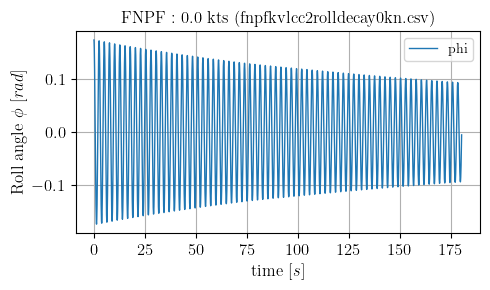

In [21]:
meta_data = content.loc[1]
data = load(meta_data['data file'])
renames = {
    'phi' : symbols.phi,
    'phi1d' : symbols.phi_dot,
    'phi2d' :symbols.phi_dot_dot,
}
#data.rename(columns=renames, inplace=True)
rolldecay.plot(data,y='phi', meta_data=meta_data);

In [22]:
data.head()

phi     phi1d     phi2d            V1
Time                                            
0.02  0.174388 -0.018087 -1.091653  3.082352e-11
0.04  0.173809 -0.039806 -1.082627 -3.701665e-05
0.06  0.172796 -0.061389 -1.074681 -7.304180e-05
0.08  0.171354 -0.082849 -1.065540 -1.121690e-04
0.10  0.169484 -0.104042 -1.056223 -1.409602e-04

In [23]:
X = diff_eq_cubic.calculate_features(data=data)

In [24]:
y = diff_eq_cubic.calculate_label(y=data['phi2d'])

The coefficients determined with Ordinary Least Square fit is shown in Tab.[(below)](#tab_parameters_one). The mean value of these coefficients are presented togehter with 5\% confidence level intervalls. 

In [25]:
model = sm.OLS(y,X)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  phi2d   R-squared (uncentered):                   1.000
Model:                            OLS   Adj. R-squared (uncentered):              1.000
Method:                 Least Squares   F-statistic:                          1.053e+08
Date:                Wed, 02 Jun 2021   Prob (F-statistic):                        0.00
Time:                        12:55:06   Log-Likelihood:                          42714.
No. Observations:                9000   AIC:                                 -8.542e+04
Df Residuals:                    8994   BIC:                                 -8.537e+04
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
B_3A           0.0981      0.013      7.444      0.000       0.072       0.124
C_3A          -5.5215      0.146    -37.941      0.000      -5.807      -5.236
C_5A         254.0934      4.678     54.312      0.000     244.923     263.264
B_2A          -0.0617      0.007     -8.508      0.000      -0.076      -0.047
B_1A           0.0163      0.001     16.878      0.000       0.014       0.018
C_1A           6.1162      0.001   6055.181      0.000       6.114       6.118
==============================================================================
Omnibus:                      496.814   Durbin-Watson:                   1.632
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1895.581
Skew:                          -0.126   Prob(JB):                         0.00
Kurtosis:                       5.234   Cond. No.                     4.97e+04
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 4.97e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<a id="tab_parameters_one"></a>

In [26]:
df_results = src.visualization.regression.results_summary_to_dataframe(results)

src.visualization.regression.result_table(df_results, 
                                          caption='Parameters estimation cubic model (5\% confidence)', 
                                          label='parameters_one')


[Index(['coeff', 'mean', '$P_{value}$', '$conf_{lower}$', '$conf_{higher}$'], dtype='object'),
 array(['', '', '', '', ''], dtype=object),
 array(['$B_{3A}$', 0.098, 0.0, 0.072, 0.124], dtype=object),
 array(['$C_{3A}$', -5.522, 0.0, -5.807, -5.236], dtype=object),
 array(['$C_{5A}$', 254.093, 0.0, 244.923, 263.264], dtype=object),
 array(['$B_{2A}$', -0.062, 0.0, -0.076, -0.047], dtype=object),
 array(['$B_{1A}$', 0.016, 0.0, 0.014, 0.018], dtype=object),
 array(['$C_{1A}$', 6.116, 0.0, 6.114, 6.118], dtype=object)]

## Simulation
Fig.[(below)](#fig_sim_cubic) shows a simulation with the regressed parameters together with the original data from the FNPF simulations. The simulations are conducted by solving the intial value problem by Runge Kutta integration of Eq.[(above)](#eq_acceleration_equation_cubic).

In [27]:
df_results = src.visualization.regression.results_summary_to_dataframe(results)
df_sim = simulate(data=data, df_results=df_results, lambda_phi2d=diff_eq_cubic.acceleration_lambda)

<a id="fig_sim_cubic"></a>

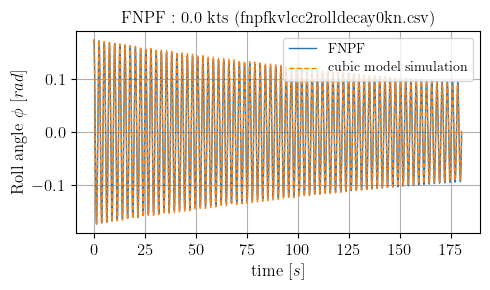

In [28]:
fig,ax=plt.subplots()
rolldecay.plot(data, y='phi', ax=ax, label='FNPF')
rolldecay.plot(df_sim, y='phi', ax=ax, label='cubic model simulation', style='--', meta_data=meta_data)
ax.legend();

The $P_{value}$ is shown for each parameter in Tab.[(above)](#tab_parameters_one) testing the null hypothesis $H_0$ for each parameter. $H_0$ tests the probability that a certain parameter would be 0 (so that it can be removed). For this case the $P_{value}$ is close to 0 for all parameters, which means that none of them should be removed. 

It can however be noted that the lower and upper limits of the \5% confidence intervalls differs quite a bit. In the following, a simpler linear model will therefore also be investigated, to see if there is a need to reduce the complexity of this model. For a linear model, the differential equation for the roll motions is reduced to:

In [29]:
acceleration_equation_linear = diff_eq_cubic.acceleration_equation.subs([
    (B_2A,0),
    (B_3A,0),
    (C_3A,0),
    (C_5A,0),
    
])
Equation(acceleration_equation_linear, acceleration_equation_linear)

<src.notebook_to_latex.Equation object>

In [30]:
diff_eq_linear = regression.DiffEqToMatrix(roll_decay_equation=acceleration_equation_linear)

In [31]:
Equation(diff_eq_linear.acceleration_equation_x,'acceleration_equation_linear_x')

<src.notebook_to_latex.Equation object>

The $\beta$ and $X$ is now expressed as:

In [32]:
Equation(diff_eq_linear.eq_beta,'eq_beta2')

<src.notebook_to_latex.Equation object>

In [33]:
Equation(diff_eq_linear.eq_X,'eq_X2')

<src.notebook_to_latex.Equation object>

In [34]:
X2 = diff_eq_linear.calculate_features(data=data)
model2 = sm.OLS(y,X2)
results2 = model2.fit()
results2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  phi2d   R-squared (uncentered):                   1.000
Model:                            OLS   Adj. R-squared (uncentered):              1.000
Method:                 Least Squares   F-statistic:                          1.815e+08
Date:                Wed, 02 Jun 2021   Prob (F-statistic):                        0.00
Time:                        12:55:07   Log-Likelihood:                          40218.
No. Observations:                9000   AIC:                                 -8.043e+04
Df Residuals:                    8998   BIC:                                 -8.042e+04
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
B_1A           0.0072      0.000     55.819      0.000       0.007       0.007
C_1A           6.1007      0.000   1.91e+04      0.000       6.100       6.101
==============================================================================
Omnibus:                     1423.706   Durbin-Watson:                   0.942
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            26669.321
Skew:                           0.012   Prob(JB):                         0.00
Kurtosis:                      11.433   Cond. No.                         2.47
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The parameter estimation for the linear model is shown in Tab.[(below)](#tab_parameters2). It can be noted that the upper and lower limits of the confidence intervalls are now much closer to each other. A simulation with this linear model is shown in Fig.[(below)](#fig_sim_linear).

<a id="#tab_parameters2"></a>

In [35]:
df_results2 = src.visualization.regression.results_summary_to_dataframe(results2)
src.visualization.regression.result_table(df_results2, caption='Parameters estimation linear model (5\% confidence)', label='parameters2')

[Index(['coeff', 'mean', '$P_{value}$', '$conf_{lower}$', '$conf_{higher}$'], dtype='object'),
 array(['', '', '', '', ''], dtype=object),
 array(['$B_{1A}$', 0.007, 0.0, 0.007, 0.007], dtype=object),
 array(['$C_{1A}$', 6.101, 0.0, 6.1, 6.101], dtype=object)]

<a id="fig_sim_linear"></a>

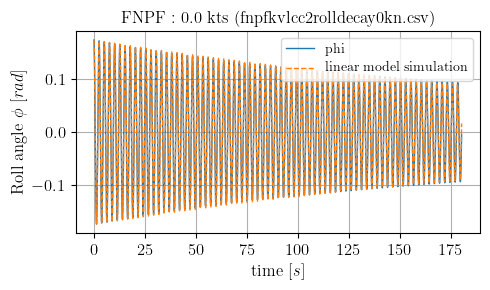

In [36]:
df_results2 = src.visualization.regression.results_summary_to_dataframe(results2)
df_sim2 = simulate(data=data, df_results=df_results2, lambda_phi2d=diff_eq_linear.acceleration_lambda)

fig,ax=plt.subplots()
rolldecay.plot(data, y='phi', ax=ax)
rolldecay.plot(df_sim2, y='phi', ax=ax, label='linear model simulation', style='--', meta_data=meta_data)
ax.legend();

In [37]:
r2_cubic = r2_score(y_true=data['phi'], y_pred=df_sim['phi'])
r2_linear = r2_score(y_true=data['phi'], y_pred=df_sim2['phi'])

Markdown(f"""The coefficient of determination $R^2$ is very similar between the cubic ({np.round(r2_cubic,3)}) and 
         the linear model  ({np.round(r2_linear,3)}), when comparing simulated roll signal with the corresponding data from FNPF.""") 

The coefficient of determination $R^2$ is very similar between the cubic (0.997) and 
         the linear model  (0.989), when comparing simulated roll signal with the corresponding data from FNPF.

## Model tests
Fig.[(below)](#fig_roll_decay_model_test) shows the roll signal from one of the roll decay model tests. A sample from this signal as indicated by the "cut" in Fig.[(below)](#fig_roll_decay_model_test) is used to regress the roll damping. The roll velocity and acceleration are however missing from this model test data. This means that the regression approach as used for the FNPF data cannot be used  directly. Instead the velocity and acceleration are first estimated using numerical differentiation. The acceleration and velocity signals estimated in this way are very noisy as shown in Fig.[(below)](#fig_roll_velocity_and_acceleration), where the roll angle measurement noise is included in the differentiation. The roll signal has been low pass filtered prior to the differentiation. The signal has been filtered using a linear digital filter twice: once forward and once backwards. This "filt-filt" approach ensures that the filter is not introducing a phase lag onto the signal, which is crucial for the present regression. A 5th order digital filter with 15 Hz cutoff frequency was used for the filtering. 

Results from a regression with this noisy data is shown in Fig.[(below)](#fig_roll_acceleration_ols), where the numerical acceleration and a 5\% confidence intervall is also shown. Fig.[(below)](#fig_roll_acceleration_residual) shows the residual distribution. This distribution seems to be approximatelly normal distributed, which is confirmed when also looking at the normal probability plot in Fig.[(below)](#fig_residual_normal_probability_plot).




<a id="fig_roll_decay_model_test">

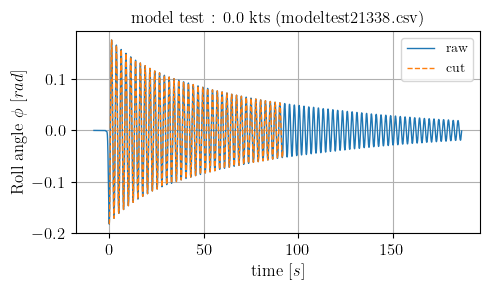

In [38]:
meta_data = content.loc[3]
data_raw = load(meta_data['data file'])

## Filter
def filter_diff(data):
    
    ts = np.mean(np.diff(data.index))
    fs = 1/ts
    data['phi_raw'] = data['phi'].copy()
    data['phi'] = filters.lowpass_filter(data=data['phi'], cutoff=15, fs=fs, order=5)
    
    dt = np.mean(np.diff(data.index))
    data['phi1d'] = np.gradient(data['phi'],dt)
    data['phi2d'] = np.gradient(data['phi1d'],dt)
    
    return data

data = filter_diff(data=data_raw)
index = data['phi'].abs().idxmax()
data = data.loc[index:100].copy()

t0 = float(data.index[0])
data.index-=t0
data_raw.index-=t0

ax = rolldecay.plot(data_raw,y='phi', label='raw');
rolldecay.plot(data,y='phi', label='cut', style='--', ax=ax, meta_data=meta_data);



<a id="fig_roll_velocity_and_acceleration"></a>

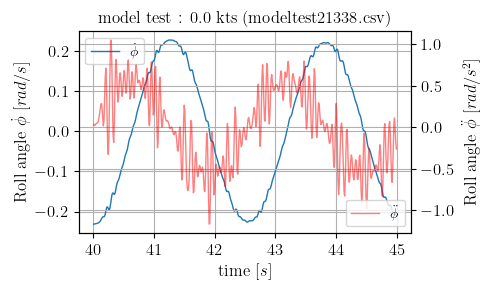

In [39]:


data_ = data.loc[40:45]

ax = rolldecay.plot(data=data_, y='phi1d', label='$\dot{\phi}$')
ax.legend(loc='upper left')
ax2 = ax.twinx()
rolldecay.plot(data=data_, y='phi2d', style='r-', label=r'$\ddot{\phi}$', ax=ax2, alpha=0.5, meta_data=meta_data)
ax2.legend(loc='lower right');

#rolldecay.plot(data=data_, y='phi2d', ax=ax)

In [40]:
y = diff_eq_cubic.calculate_label(y=data['phi2d'])
X3 = diff_eq_cubic.calculate_features(data=data)
model3 = sm.OLS(y,X3)
results3 = model3.fit()
results3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  phi2d   R-squared (uncentered):                   0.830
Model:                            OLS   Adj. R-squared (uncentered):              0.830
Method:                 Least Squares   F-statistic:                              7475.
Date:                Wed, 02 Jun 2021   Prob (F-statistic):                        0.00
Time:                        12:55:11   Log-Likelihood:                          1832.1
No. Observations:                9193   AIC:                                     -3652.
Df Residuals:                    9187   BIC:                                     -3609.
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
B_3A          -0.1327      1.284     -0.103      0.918      -2.650       2.385
C_3A           7.4409     13.568      0.548      0.583     -19.155      34.037
C_5A         -88.1585    455.809     -0.193      0.847    -981.645     805.328
B_2A           0.1319      0.668      0.197      0.843      -1.177       1.441
B_1A           0.0088      0.080      0.109      0.913      -0.149       0.166
C_1A           6.0459      0.081     74.555      0.000       5.887       6.205
==============================================================================
Omnibus:                      187.017   Durbin-Watson:                   0.564
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              406.316
Skew:                           0.018   Prob(JB):                     5.88e-89
Kurtosis:                       4.029   Cond. No.                     4.03e+04
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 4.03e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [41]:
y = diff_eq_linear.calculate_label(y=data['phi2d'])
X4 = diff_eq_linear.calculate_features(data=data)
model4 = sm.OLS(y,X4)
results4 = model4.fit()
results4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  phi2d   R-squared (uncentered):                   0.830
Model:                            OLS   Adj. R-squared (uncentered):              0.830
Method:                 Least Squares   F-statistic:                          2.243e+04
Date:                Wed, 02 Jun 2021   Prob (F-statistic):                        0.00
Time:                        12:55:11   Log-Likelihood:                          1831.1
No. Observations:                9193   AIC:                                     -3658.
Df Residuals:                    9191   BIC:                                     -3644.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
B_1A           0.0322      0.012      2.758      0.006       0.009       0.055
C_1A           6.1152      0.029    211.792      0.000       6.059       6.172
==============================================================================
Omnibus:                      187.004   Durbin-Watson:                   0.564
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              406.315
Skew:                           0.018   Prob(JB):                     5.88e-89
Kurtosis:                       4.029   Cond. No.                         2.47
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [42]:
df_results3 = src.visualization.regression.results_summary_to_dataframe(results3)

src.visualization.regression.result_table(df_results3, 
                                          caption='Parameters estimation cubic model', label='parameters3')

[Index(['coeff', 'mean', '$P_{value}$', '$conf_{lower}$', '$conf_{higher}$'], dtype='object'),
 array(['', '', '', '', ''], dtype=object),
 array(['$B_{3A}$', -0.133, 0.918, -2.65, 2.385], dtype=object),
 array(['$C_{3A}$', 7.441, 0.583, -19.155, 34.037], dtype=object),
 array(['$C_{5A}$', -88.159, 0.847, -981.645, 805.328], dtype=object),
 array(['$B_{2A}$', 0.132, 0.843, -1.177, 1.441], dtype=object),
 array(['$B_{1A}$', 0.009, 0.913, -0.149, 0.166], dtype=object),
 array(['$C_{1A}$', 6.046, 0.0, 5.887, 6.205], dtype=object)]

In [43]:
df_results4 = src.visualization.regression.results_summary_to_dataframe(results4)

src.visualization.regression.result_table(df_results4, 
                                          caption='Parameters estimation linear model', label='parameters4')


[Index(['coeff', 'mean', '$P_{value}$', '$conf_{lower}$', '$conf_{higher}$'], dtype='object'),
 array(['', '', '', '', ''], dtype=object),
 array(['$B_{1A}$', 0.032, 0.006, 0.009, 0.055], dtype=object),
 array(['$C_{1A}$', 6.115, 0.0, 6.059, 6.172], dtype=object)]

<a id="fig_roll_acceleration_ols"></a>

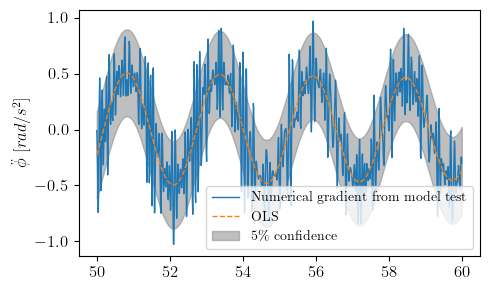

In [44]:
X_ = X4.loc[50:60]
y_ = y.loc[X_.index]
y_pred = results4.predict(X_)
phi2d_pred = -y_pred

prstd, iv_l, iv_u = wls_prediction_std(results4, exog=X_, alpha=0.05)
iv_l*=-1 
iv_u*=-1

fig,ax=plt.subplots()
ax.plot(X_.index,-y_, label='Numerical gradient from model test')
ax.plot(X_.index,phi2d_pred, '--', label='OLS')
ax.set_ylabel(r'$\ddot{\phi}$ $[rad/s^2]$')

ax.fill_between(X_.index, y1=iv_l, y2=iv_u, zorder=-10, color='grey', alpha=0.5, label=r'5\% confidence')
ax.legend();

<a id="fig_roll_acceleration_residual"></a>

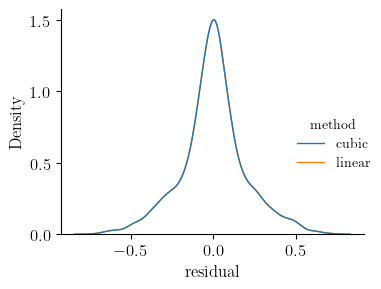

In [45]:
df_residuals = pd.DataFrame()
df_ = pd.DataFrame(results3.resid,columns=['residual'])
df_['method'] = 'cubic'
df_residuals = df_residuals.append(df_, ignore_index=True)
df_ = pd.DataFrame(results4.resid,columns=['residual'])
df_['method'] = 'linear'
df_residuals = df_residuals.append(df_, ignore_index=True)

sns.displot(df_residuals, x='residual', kind="kde", hue='method', bw_adjust=1, height=3);


<a id="fig_residual_normal_probability_plot"></a>

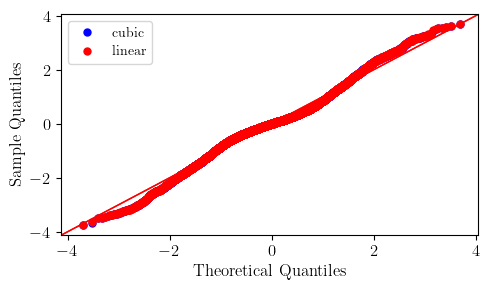

In [46]:
fig,ax=plt.subplots()
sm.qqplot(results3.resid, line = "45", fit = True, ax=ax, label='cubic');
sm.qqplot(results4.resid, line = "45", fit = True, ax=ax, label='linear', color='red', markerfacecolor='red');
ax.legend();

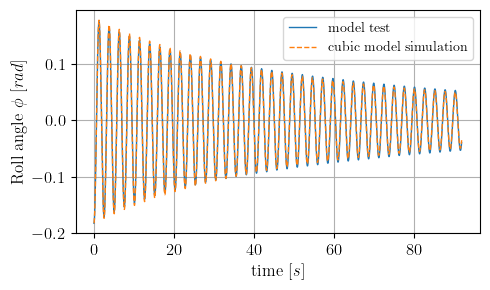

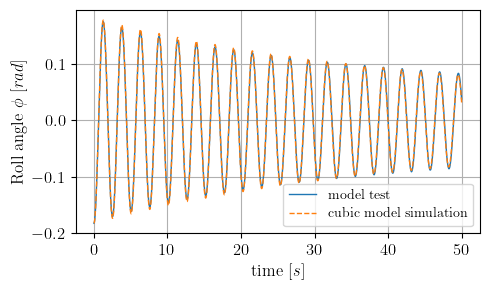

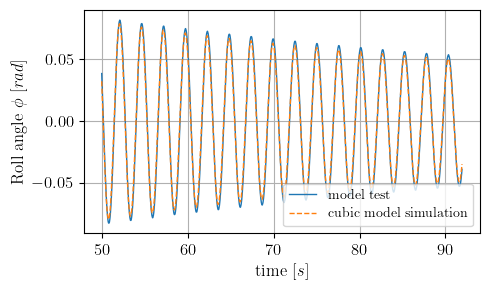

In [47]:
df_results3 = src.visualization.regression.results_summary_to_dataframe(results3)
df_sim3 = simulate(data=data, df_results=df_results3, lambda_phi2d=diff_eq_cubic.acceleration_lambda)

fig,ax=plt.subplots()
rolldecay.plot(data, y='phi', label='model test', ax=ax)
rolldecay.plot(df_sim3, y='phi', ax=ax, label='cubic model simulation', style='--')
ax.legend();

fig,ax=plt.subplots()
rolldecay.plot(data.loc[0:50], y='phi', label='model test', ax=ax)
rolldecay.plot(df_sim3.loc[0:50], y='phi', ax=ax, label='cubic model simulation', style='--')
ax.legend();


fig,ax=plt.subplots()
rolldecay.plot(data.loc[50:], y='phi', label='model test', ax=ax)
rolldecay.plot(df_sim3.loc[50:], y='phi', ax=ax, label='cubic model simulation', style='--')
ax.legend();


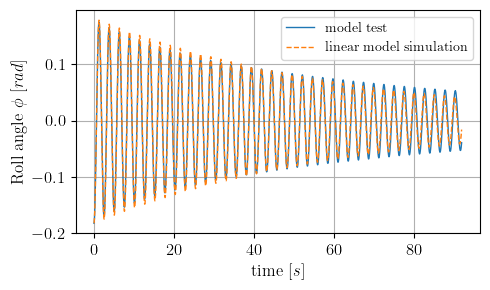

In [48]:
df_results4 = src.visualization.regression.results_summary_to_dataframe(results4)
df_sim4 = simulate(data=data, df_results=df_results4, lambda_phi2d=diff_eq_linear.acceleration_lambda)

fig,ax=plt.subplots()
rolldecay.plot(data, y='phi', label='model test', ax=ax)
rolldecay.plot(df_sim4, y='phi', ax=ax, label='linear model simulation', style='--')
ax.legend();

In [49]:
r2_cubic = r2_score(y_true=data['phi'], y_pred=df_sim3['phi'])
r2_linear = r2_score(y_true=data['phi'], y_pred=df_sim4['phi'])

Markdown(f"""The coefficient of determination $R^2$ is slightly higher for the cubic model ({np.round(r2_cubic,3)}) compared to 
the the linear model  ({np.round(r2_linear,3)}), when comparing simulated roll signal with the corresponding data from the model test.""") 

The coefficient of determination $R^2$ is slightly higher for the cubic model (0.997) compared to 
the the linear model  (0.982), when comparing simulated roll signal with the corresponding data from the model test.

## Validation
The other model test at 0 knots (see Fig.[(below)](#fig_other_roll_decay)) is used for validation of the regression models.

<a id="fig_other_roll_decay"></a>

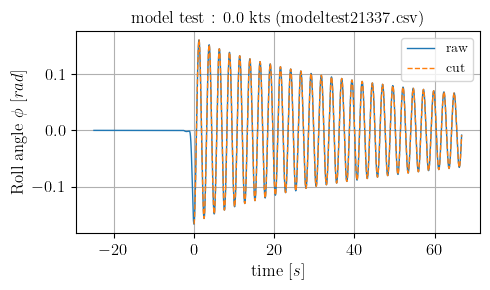

In [50]:
meta_data = content.loc[2]
data_raw = load(meta_data['data file'])

data = filter_diff(data=data_raw)
index = data['phi'].abs().idxmax()
data = data.loc[index:100].copy()

t0 = float(data.index[0])
data.index-=t0
data_raw.index-=t0

ax = rolldecay.plot(data_raw,y='phi', label='raw');
rolldecay.plot(data,y='phi', label='cut', style='--', ax=ax, meta_data=meta_data);

In [51]:
dt = np.mean(np.diff(data.index))
data['phi1d'] = np.gradient(data['phi'],dt)
data['phi2d'] = np.gradient(data['phi1d'],dt)

df_sim5 = simulate(data=data, df_results=df_results3, lambda_phi2d=diff_eq_cubic.acceleration_lambda)
df_sim6 = simulate(data=data, df_results=df_results4, lambda_phi2d=diff_eq_linear.acceleration_lambda)

Fig.[(below)](#fig_other_roll_decay_sim) shows a comparison with this model test and simulations with regressed parameters from the first model test.

<a id="fig_other_roll_decay_sim"></a>

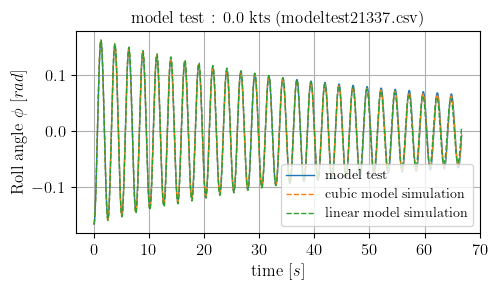

In [52]:
fig,ax=plt.subplots()
rolldecay.plot(data, y='phi', label='model test', ax=ax)
rolldecay.plot(df_sim5, y='phi', ax=ax, label='cubic model simulation', style='--', meta_data=meta_data)
rolldecay.plot(df_sim6, y='phi', ax=ax, label='linear model simulation', style='--', meta_data=meta_data)
ax.legend();

In [53]:
r2_cubic = r2_score(y_true=data['phi'], y_pred=df_sim5['phi'])
r2_linear = r2_score(y_true=data['phi'], y_pred=df_sim6['phi'])

Markdown(f"""The coefficient of determination $R^2$ is similar for the cubic model ({np.round(r2_cubic,3)}) compared to 
the the linear model  ({np.round(r2_linear,3)}), when comparing simulated roll signal with the corresponding data from the model test.""") 

The coefficient of determination $R^2$ is similar for the cubic model (0.998) compared to 
the the linear model  (0.992), when comparing simulated roll signal with the corresponding data from the model test.

# Conclusions
The parameters in a cubic and a linear roll decay motion model have been estimated by fitting a linear regression with ordinary least square fit to roll decay tests time series at 0 knots ship speed. The regression was validated by comparing simulated roll signals (including the regressed parameters) with the original roll signals. The coefficient of determination $R^2$ was slightly higher for the cubic model (suggesting higher accuracy) compared to the linear model for the investigation of the FNPF data. 

For the model test data, a numerical differentiation was used to estimate the roll velocity and acceleration, as these signals were otherwise missing from the model test data. The numerical estimates for these signals were unfortunatelly very noisy. The residuals from the fitted models with these noisy signals was however found to be normal distributed. These residuals most likely origins from a normal distributed measurement noise. The noisy signals gave a large spread between the lower and upper limits of the regressed parameter confidence intervalls. But since the residuals were normal distributed, the mean values of these parameter estimations gave a high accuracy when evaluating with simulations. For the first model test, which was a very long test in time, the cubic model gave a bit better accuracy. Also using the regressed parameters to simulate a complete new dataset from the second model test (a test not seen by the regression) gave good accuracy for the two models.

For a shorter time span and amplitude span the linear model gives good accuracy. For longer time and amplitude spans the cubic model seems to be a better alternative. The parameter confidence intervalls of the cubic model have larger spreadings, which will make direct comparison of parameter values, for instance between two different ships, or two different speeds more unreliable.   




# References
<div class="cite2c-biblio"></div>